<a href="https://colab.research.google.com/github/fatima-bukhari5/liveness_detection_colab/blob/main/Liveness_VGG16_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Imports

In [7]:
# Reference section to call important lib.

# mathemathical & data manupulation
import numpy as np          # numpy for mathemathical operations
import pandas as pd         # to manage data in two dimension structures

# O/S, command line, serialization, deserialization, iterations
import argparse             # command line arguments management.
import pickle               # pickle for object serialization/de-serialization
import os                   # to interact with operating system
import itertools            # to enhance iteration over object, i.e. for loop

# image processing
import cv2                  # opencv for image pre-processing
from imutils import paths   # another convienance for image processing like opencv

# For Data visualization & charts
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Reference to Scikit Learn for data pre-processing & post training
# performance evaluation. 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Reference to keras with tensorflow engine for model training.
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.models import Model
from keras.layers.core import Dense, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


### Importing Data Sets

In [8]:
INIT_LR = 0.0001  # a variable for learning rate parameter while training
BS = 10           # ??????
EPOCHS = 16        # a variable for number of epochs parameter while training model

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# location for training, validation & testing dataset 
train_path = '/content/drive/MyDrive/real_and_fake/train'
valid_path = '/content/drive/MyDrive/real_and_fake/valid'
test_path = '/content/drive/MyDrive/real_and_fake/test'

In [21]:
def read_image_data(X,Y):
    '''
    The following function is to convert the data into numpy array through
    `data_processing` function and resize it according vgg16 input size 
    of 224 by 224.
    
    Requirement:  Convert input images to 224x224 for VGG16
    Usage:        Pre-Processing.
    Functionality:
                  1. load images one by one from folder, resize & attach lable.
                  2. Convert image to numpy array & return array with lable. 
    Parameters:
                  X => df['Image paths'] (dataframe column of image paths)
                  Y => df['Labels'] (dataframe column of image labels)

    Returns:      `image` in the form of numpy array & labels as encoded.
    '''
    # to do: variables & parmeters naming convention.
    # declaration Section
    data =[]                                      # An array to hold images.
    labels = Y                                    # A variable to hold label from parameter.
    # execution section    
    # to do: exception handling
    for path in X:                                # for each image in a given folder.
        image = cv2.imread(path)                  # reading image from given path.
        image = cv2.resize(image,(224,224))       # resizing image as of input requirement.
        data.append(image)                        # add image to declared array structure.
    data, labels = data_processing(data, labels)  # Calling & passing parameters to data_processing function.
    # to do: use python log api for console message, if any. print is childish.
    print('[INFO] Converting Data into Image form and encoding labels')
    # return section
    return data, labels

In [22]:
def data_organization(img_path):
    '''
    This function is to organize the data in the form of data frames to have clear understanding 
    and readability of data w.r.t to its labels

    Parameters: 
    img_path = folder path of images base folder as string

    Returns: dataframe with organized image paths and their labels
    '''
    print("Getting labels for images...")
    data = []
    labels = []
    list_image_path = []
    folders_list = os.listdir(img_path)
    
    # loop over all folders at a time. i.e real and fake
    for folder in folders_list:
        
        # extract the class label from the filename to add into the df
    
        folder_path = os.path.join(img_path,folder)
        images_list = os.listdir(folder_path)
        for image_name in images_list:
            label = folder
            imagePath = os.path.join(folder_path,image_name)
            labels.append(label)
            list_image_path.append(imagePath)
            
    image_path_label = {'image_path': list_image_path,'labels':labels}
    df_image_path_label = pd.DataFrame(image_path_label)
    
    print("DataFrame Complete....")
    return df_image_path_label

In [23]:
def data_processing(data,labels):
    '''
    Data processing to convert images data to numpy along with label encoding
    
    Parameters:
    data -> list of images data
    labels -> list of labels
    
    returns:
    data, labels as numpy array of image data and encoded labels
    '''
    data = np.array(data, dtype="float")
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels, 2)
    
    return data, labels

## Build Fine-tuned VGG16 model

VGG16 Model was used in an ImageNet competition where thousands of images were classified into different categories. We'll be using this model as a baseline and fine tune it as to our specific requirements. 
VGG16 in itself is a model that classifies images into a number of classes that are not limited to just two. In our case the output layer requires just two nodes representing two classes as `real` and `fake`. So, we will be tuning the model accordingly. 
<br>
<br>

Importing the model will take time as its a file of size almost 17 MB 

In [24]:
def model_training(train_data, train_labels, val_data, val_labels):
    '''
    The function is involved with 
        - data augmentation 
        - sequential model initialization
        - using vgg16 model layers as base layers for the new model.
        - compiling the model
        - training the model
    
    returns a trained model file
    '''
    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
        horizontal_flip=True, fill_mode="nearest")
   
    print("[INFO] importing VGG16 ")
    vgg16_model = keras.applications.vgg16.VGG16(include_top=True)
    
    # getting a sequential model and freezing the previous
    model = Sequential()
    for layer in vgg16_model.layers[:-1]:
        model.add(layer)
    
    # After poping the last layer, freeze the previous layers and adding a new dense output layer
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(2, activation='softmax'))
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = Adam(lr=INIT_LR)
    
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    # train the network
    print("[INFO] training network for {} epochs...".format(EPOCHS))
    
    model.fit(x=aug.flow(train_data, train_labels, batch_size=BS),
        validation_data=(val_data, val_labels), validation_steps=5, steps_per_epoch=len(train_data) / BS,
        epochs=EPOCHS)
    
    return model

In [25]:
def get_predictions(model, df_testing):
    '''
    Getting predictions w.r.t to the trained model as passed and the training data
    
    Parameters:
    model: trained model
    df_testing: data for testing in the form of dataframe
    
    Returns:
    
    Predictions as 0 or 1 and true_labels after data processing
    '''
    
    # getting test data in numpy 
    test_data, true_labels = read_image_data(df_testing['image_path'], df_testing['labels']) 
    
    # gettin predictions against the model
    print('[INFO] Getting Predictions')
    predictions = model.predict(test_data, steps=1, verbose=0)
    predictions_rounded = np.round(predictions)
    
    return predictions_rounded, true_labels

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
def model_performance(predictions, true_labels):
    '''
    The model displays a confusion matrix using a previously built confusion matrix function taken from sklearn.
    
    Parameters:
    predictions: previous predictions
    true_labels: array of actual labels to be compared
    
    Result: dislay confusion matrix
    '''
    print('[INFO] Getting Confusion Matrix')
    cm = confusion_matrix(true_labels[:,0], predictions[:,0])
    

    cm_plot_labels = ['real','fake']
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
    

In [28]:
def main():
    '''
    calling all functions
    '''
    
    # getting labels to each data set
    df_training = data_organization(train_path)
    df_validation = data_organization(valid_path)
    df_testing = data_organization(test_path)
    
    # getting train and validation data in numpy 
    train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'])
    val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'])
    
    # get the trained model
    model = model_training(train_data=train_data, train_labels=train_labels, 
                           val_data=val_data, val_labels=val_labels)
    
    # get the results
    predictions, true_labels = get_predictions(model = model, df_testing=df_testing)
    
    #
    model_performance(predictions=predictions, true_labels=true_labels)

Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
[INFO] importing VGG16 
553476096/553467096 [==============================] - 3s 0us/step
[INFO] compiling model...
[INFO] training network for 16 epochs...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/16
30/30 [==============================] - 18s 221ms/step - loss: 0.9415 - accuracy: 0.4633 - val_loss: 0.6749 - val_accuracy: 0.7100
Epoch 2/16
30/30 [==============================] - 4s 144ms/step - loss: 0.7793 - accuracy: 0.5900 - val_loss: 0.4354 - val_accuracy: 0.8800
Epoch 3/16
30/30 [==============================] - 4s 146ms/step - loss: 0.6380 - accuracy: 0.6933 - val_loss: 0.3283 - val_accuracy: 0.9500
Epoch 4/16
30/30 [==============================] - 4s 147ms/step - loss: 0.5746 - accuracy: 0.7333 - val_loss: 0.2675 - val_accuracy: 0.9500
Epoch 5/16
30/30 [==============================] - 4s 142ms/step - loss: 0.5234 - accuracy: 0.7733 - val_loss: 0.2200 - val_accuracy: 0.9600
Epoch 6/16
30/30 [==============================] - 4s 143ms/step - loss: 0.4663 - accuracy: 0.8100 - val_loss: 0.2127 - val_accuracy: 0.9400
Epoch 7/16
30/30 [==============================] - 4s 146ms/step - loss: 0.4597 - accuracy: 0.8333 - val_loss: 0.1954 - val_accuracy: 0.9400
Epoch

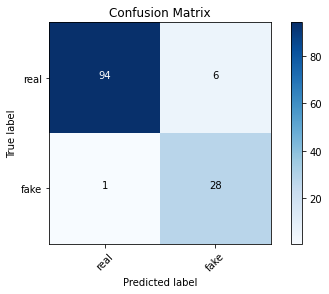

In [29]:
main()

### Mobile Net

In [ ]:
mobile = keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         